# Применение моделей машинного обучения для обнаружения сетевых атак

In [ ]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

Описание датасета https://www.unb.ca/cic/datasets/nsl.html


Файл с данными:
https://drive.google.com/file/d/19SK6HfVjDTmvDB82mqpLjJPWmd7XHrVv/view?usp=sharing

## Загрузка данных

Загрузите датасет и получите информацию о нем.

In [1]:
df1 = ...

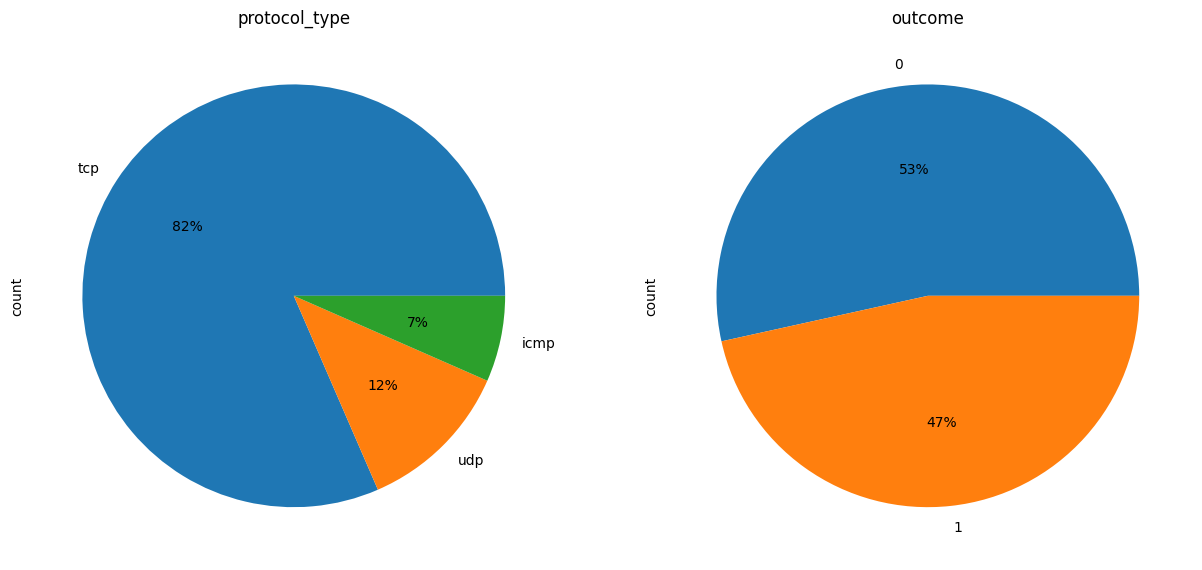

In [ ]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()
pie_plot(df1, ['protocol_type', 'outcome'], 1, 2)

## Предварительная обработка данных

In [ ]:
df1.loc[df1['outcome'] == "normal", "outcome"] = 'normal'
df1.loc[df1['outcome'] != 'normal', "outcome"] = 'attack'

In [ ]:
df1['level'].unique(), df1['outcome'].unique()

(array([20, 15, 19, 21, 18, 17, 16, 12, 14, 11,  2, 13, 10,  9,  8,  7,  3,
         5,  1,  6,  0,  4]),
 array(['normal', 'attack'], dtype=object))

In [ ]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    ...
    std_df = ...
    return std_df

In [ ]:
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

In [ ]:
df2 = preprocess(df1)

In [ ]:
df2.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,land,logged_in,is_host_login,is_guest_login,level,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,0.000198,0.395736,0.000008,0.009423,19.504060,287.144650,164.937475,38.331617,0.022687,0.000111,0.204409,0.001222,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.000000,0.497217,1.233618,0.284485,0.282485,0.119958,0.121183,-0.372607,1.050877,0.097322,-0.421104,0.214910,0.011833,0.899302,2.472981,1.627122,0.284452,0.278485,0.118832,0.120240
std,0.014086,0.489010,0.002817,0.096612,2.291503,2604.515310,21269.315876,7793.157270,0.253530,0.014366,2.149968,0.045239,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.000000,0.812118,4.539740,0.446456,0.447022,0.320436,0.323647,0.483102,3.005240,0.259830,0.573446,0.451848,0.472578,2.698883,5.149952,5.628190,0.444784,0.445669,0.306557,0.319459
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.159420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.099291,-0.500000,0.000000,0.000000,0.000000,0.000000,-1.098901,0.000000,0.000000,-1.473988,-0.257143,-0.536842,-0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,-0.159420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.085106,-0.375000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,-0.216327,-0.484211,-0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.840580,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.914894,0.625000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.783673,0.515789,0.714286,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,21.000000,42908.000000,4999869.000000,2538638.374031,3.000000,3.000000,77.000000,5.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.000000,3.524823,31.437500,1.000000,1.000000,1.000000,1.000000,0.000000,16.666667,1.000000,0.000000,0.783673,0.515789,14.000000,16.666667,50.000000,1.000000,1.000000,1.000000,1.000000


## Анализ главных компонент

Анализ главных компонент, или PCA, — это статистический метод преобразования данных высокой размерности в данные низкой размерности путем выбора наиболее важных признаков, которые содержат максимальную информацию о наборе данных. Признаки выбираются на основе дисперсии, которую они вызывают в выходных данных. Признак, который вызывает самую высокую дисперсию, является первым главным компонентом. Признак, который отвечает за вторую по величине дисперсию, считается вторым главным компонентом и т. д. Важно отметить, что главные компоненты не имеют никакой корреляции друг с другом.

Преимущества PCA
Существует два основных преимущества снижения размерности с помощью PCA.

Время обучения алгоритмов значительно сокращается при меньшем количестве признаков.
Не всегда возможно анализировать данные в высоких размерностях. Например, если в наборе данных 100 признаков. Общее количество диаграмм рассеяния, необходимых для визуализации данных, составит 100(100-1)2 = 4950. На практике анализировать данные таким образом невозможно.


In [ ]:
X = df2.drop(['outcome', 'level'] , axis = 1).values
y = df2['outcome'].values

pca = PCA(n_components=20)
pca = ...
x_reduced = pca.transform(X)
print("Number of original features is {} and of reduced features is {}".format(X.shape[1], x_reduced.shape[1]))

Number of original features is 122 and of reduced features is 20


 ## Разделение данных на обучающую и тестовую выборки

In [ ]:
y = y.astype('int')
x_train, x_test, y_train, y_test = ...
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = ...

In [ ]:
x_train_reduced.shape, x_train.shape

((100778, 20), (100778, 122))

In [ ]:
y_train_reduced.shape, y_train.shape

((100778,), (100778,))

## Модель нейронной сети для задачи классификации

Слои

Плотный слой: полностью связанный слой, в котором каждый нейрон соединяется с каждым нейроном в следующем слое.
Сверточный слой: необходим для обработки данных изображений, захвата пространственных иерархий.
Рекуррентный слой: подходит для последовательных данных, таких как текст и временные ряды, позволяя сети сохранять информацию с течением времени.

Компиляция

Функции потерь: измеряют, насколько хорошо работает модель. Общие функции потерь включают categorical_crossentropy для классификации и mean_squared_error для регрессии.

Оптимизаторы: алгоритмы для обновления весов модели на основе функции потерь. Популярные оптимизаторы включают Adam, SGD и RMSprop.

Метрики: используются для оценки производительности модели во время обучения и тестирования, например, точности.

Обучение

Fit: обучает модель на обучающих данных. Ключевые параметры включают:
Размер пакета: количество образцов, обработанных до обновления модели.
Эпохи: количество полных проходов через обучающий набор данных.

In [ ]:
# Build the model

x_train_reduced = tf.convert_to_tensor(x_train_reduced)
y_train_reduced = tf.convert_to_tensor(y_train_reduced)

model = Sequential()

model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))


# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_reduced, y_train_reduced,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)


model.summary()



Epoch 1/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8228 - loss: 2.5050 - val_accuracy: 0.9479 - val_loss: 3.5502
Epoch 2/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9470 - loss: 9.1097 - val_accuracy: 0.9185 - val_loss: 19.8998
Epoch 3/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9384 - loss: 29.2180 - val_accuracy: 0.9612 - val_loss: 1.5057
Epoch 4/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9612 - loss: 9.7178 - val_accuracy: 0.9621 - val_loss: 7.3438
Epoch 5/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9349 - loss: 26.1884 - val_accuracy: 0.9638 - val_loss: 33.8659
Epoch 6/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9624 - loss: 14.3325 - val_accuracy: 0.9769 - val_loss: 0.1194
Epoch 7/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9621 - loss: 62.9598 - val_accuracy: 0.9524 - val_loss: 30.4936
Epoch 8/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9535 - loss: 27.2045 - val_

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_94 (Dense)                     │ (100, 64)                   │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (100, 128)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (100, 512)                  │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (100, 128)                  │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (100, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 424,517 (1.62 MB)

 Trainable params: 141,505 (552.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 283,012 (1.08 MB)

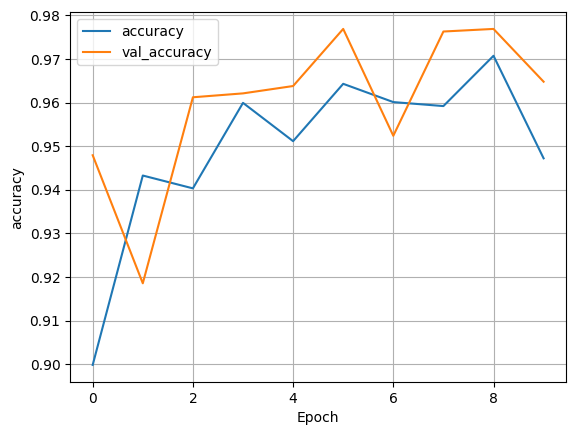

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

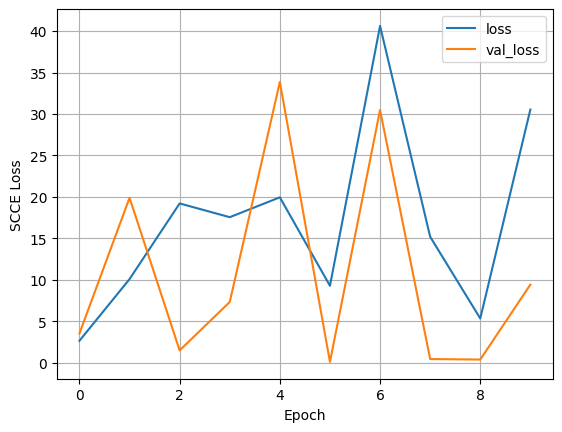

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

In [ ]:
predicted = model.predict(x_test_reduced)

788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


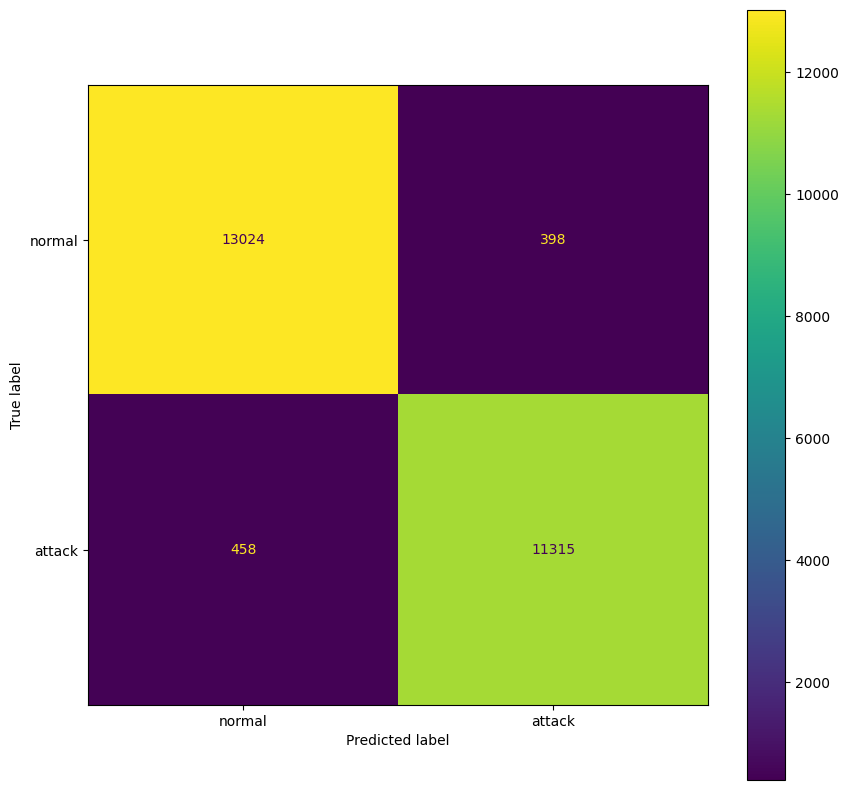

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test_reduced, predicted.round())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'attack'])
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
cm_display.plot(ax=ax)